<a href="https://colab.research.google.com/github/emekdahl/airflow-training/blob/main/Features_for_common_input_types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.

# Reference: Features for common input types
To help you get started with state-of-the-art ML modeling approaches across many domains,  this reference notebook covers some popular, robust default ways to encode inputs for common modalities. 

A fundamental component of building state-of-the-art ML systems is a good input representation $x$. The input vector defines the lens through which our ML system observes the world. If the input representation is limited or biased, this will directly impact the resulting ML system. Clever features can make the ML learning problem much simpler. For example, a 512x512 image is just a vector of 262,144 pixel intensity values to an ML model. Taking an image and _translating_ (sliding) the image left/right/up/down by even a single pixel produces an entirely different vector of pixel values! However, to a human this new image would appear almost indistinguishable from the original. By using a better feature representation than just pixel values, we can enable ML models to be more robust to such issues. 

Choosing the correct raw data is important, and representing data with useful ML features can be equally important for final system performance. See this video on "[What makes a good feature?](https://www.youtube.com/watch?v=N9fDIAflCMY)" for a nice introduction, or a more in-depth [introduction to feature engineering](https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/). 

_Featurization_ is the process of transforming raw inputs into a feature representation which is better for ML modeling. Some properties of a good feature representation:
* Robust to raw input differences that are not important for a learning task. 
* More compact / lower dimensional than original inputs in cases where original inputs are high dimensional with many correlations among features (e.g. image pixels and similar natural world signals)
* Support generalization to unseen data by being invariant across different sensing devices or perturbations in data collection

A supervised model is trained on the features, rather than the raw inputs. The processes and best practices for featurization widely differ by input modality. Featurization is not always necessary or possible when working tabular data. For common "natural signal" unstructured modalities like images, text, and audio, good features are necessary to achieve SOTA performance. Here, we provide an explanation and demonstration of popular featurization techniques across four modalities. 

### Data-centric machine learning techniques
_Feature engineering_ is the process of building good feature representations for a particular input type / dataset. This is one critical aspect of _data-centric_ machine learning techniques. Data-centric refers to any techniques where we leave our modeling solution/code unchanged, and iteratively improve the datasets used to build and/or evaluate models. By focusing on improving the data we can often create models that more closely match desired behavior and that generalize in important ways for particular domains.

In model-centric ML work, we can often quickly switch to a different mathematical formulation or try an alternative software library. Data-centric ML improvements is sometimes slower, specialized to particular datasets, or more resource intensive. Data-centric techniques are often domain-dependent, where building useful approaches relies on knowledge of input data modalities and expected input variations. 

Our course page on SOTA ML modeling techniques lists references and best practices for achieving good results with data-centric practices. See the course reading for more, but as a brief reminder the following standard data-centric improvements can often help build SOTA systems:
* Collect more data
* Improve data quality / remove input anomalies.
* Improve annotation quality and consistency.
* Try data augmentation.
* Use domain-specific feature/representation engineering (this notebook!)

### Instructions

1. This notebook is simply a reference on advanced modeling ideas like Boosting and Bagging. Reading through these ideas in depth **is optional**. You can use only the summary below to see scikit models you can try to leverage these ideas in practice. 


# Dependencies

We first setup the libraries requires for the project. Many of these may already be installed by default in Colab.

In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install xgboost
!pip install librosa

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image  # image loading library
import librosa  # speech library for loading
import xgboost as xgb  # gradient boosting library
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Numerical & Tabular Data

Unlike other modalities (which you will see next), tabular data comes featurized! But that does not mean our job is done. Often tabular data is encoded in a way that is useful for a business function, or some data collection/analysis reason other than building ML models. We can't know in general how to encode such features, but it's great to understand each feature in a tabular dataset and the meaning/semantics behind it. Simply omitting features not relevant for a particular task, or ensuring common types like dates, binary indicators, and real numbers are treated with proper normalization can help ML models. 

There are challenges unique to tabular data like missing entries. Additionally, it can be especially powerful to add new features to the existing ones for tabular data as that can make large performance differences when training a model. We will walk through several of these concepts. To illustrate them, we will be using a dataset of flight data. 

In [ ]:
!gdown --id 1lXI6eMGelD1aOWjZEkABqCo6-AWAiBtI

Downloading...
From: https://drive.google.com/uc?id=1lXI6eMGelD1aOWjZEkABqCo6-AWAiBtI
To: /content/flights.csv
100% 9.72M/9.72M [00:00<00:00, 38.7MB/s]


In [ ]:
import pandas as pd  # helpful tool for tabular data and data science generally
dataset = pd.read_csv('./flights.csv')
print(f'Number of columns: {len(dataset.columns)}')
dataset.head()

Number of columns: 29


,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,...,4.0,8.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2008,1,3,4,628.0,620,804.0,750,WN,448,...,3.0,17.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
3,2008,1,3,4,926.0,930,1054.0,1100,WN,1746,...,3.0,7.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,...,3.0,10.0,0,NaN,0,2.0,0.0,0.0,0.0,32.0


As you can see there is a mix of continuous and discrete data as well as missing entries in some columns. For our purposes, it is not very important what the individual columns are but take a close look and what kinds of values each column takes. This will determine the preprocessing we need to do!

## Standard feature normalization techniques

The different columns in tabular data contain features that can have wildly different properties: some may be binary, categorical, or continuous. Even among continuous features, they can be very different magnitudes or specialized types of values like date/time, currency values, or general values. It is important to standardize these features before training a model. 
- Binary (0/1) features are usually okay to use without normalization of any kind
- For categorical features, that means converting them to one-hotted columns.
- For continuous features, that means normalizing them by z-scoring.

### One-hot encoding of categorical features

Suppose you have a categorical feature that takes one of 5 possible classes. Rather than writing 0, 1, 2, 3, 4, we split this single feature in 5 different binary features, where each feature takes a value 0 or 1. We call this encoding _one-hot_ because only a single value in the group is non-zero at a time.

We use the mapping:
```
0 => [1, 0, 0, 0, 0]
1 => [0, 1, 0, 0, 0]
2 => [0, 0, 1, 0, 0]
3 => [0, 0, 0, 1, 0]
4 => [0, 0, 0, 0, 1]
```
Machine learning models often find one-hotted representations more friendly as they are bounded (0 or 1). Models do not need to learn to normalize the column of categorical values nor figure out the number of classes.

In [ ]:
# Replace a categorical column with one hotted representation
dataset = pd.get_dummies(
    dataset, 
    columns=['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightNum', 
             'UniqueCarrier', 'TailNum', 'Origin', 'Dest'], 
    prefix = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightNum', 
              'UniqueCarrier', 'TailNum', 'Origin', 'Dest'],
)
print(f'Number of columns: {len(dataset.columns)}')
dataset.head()

Number of columns: 3517


,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,...,Dest_SJC,Dest_SLC,Dest_SMF,Dest_SNA,Dest_STL,Dest_SYR,Dest_TPA,Dest_TUL,Dest_TUS,Dest_XNA
0,2003.0,1955,2211.0,2225,128.0,150,116.0,-14.0,8.0,810,...,0,0,0,0,0,0,1,0,0,0
1,754.0,735,1002.0,1000,128.0,145,113.0,2.0,19.0,810,...,0,0,0,0,0,0,1,0,0,0
2,628.0,620,804.0,750,96.0,90,76.0,14.0,8.0,515,...,0,0,0,0,0,0,0,0,0,0
3,926.0,930,1054.0,1100,88.0,90,78.0,-6.0,-4.0,515,...,0,0,0,0,0,0,0,0,0,0
4,1829.0,1755,1959.0,1925,90.0,90,77.0,34.0,34.0,515,...,0,0,0,0,0,0,0,0,0,0


Notice the increase in the number of columns as we added a new binary variable for every discrete option. This is expected (!) since one-hotting a categorical feature adds a number of new features equaling the number of classes. 

Next, we will normalize the continuous columns.

### Coordinate standardization ([Z-scoring](https://en.wikipedia.org/wiki/Standard_score))

For continuous valued features, ML models tend to work best when all features have 0 mean and standard deviation of approximately 1. For each feature, the technique subtracts the mean feature value, then divides by the standard deviation of the feature values. 

$$x' = \frac{x-μ}{σ + ϵ}$$

Where $\mu$ is the mean of training set feature values, $\sigma$ is the standard deviation of training set values, and $\epsilon$ is a small value (e.g. 1e-5) to avoid numerical blowup in cases where the standard deviation is very small. This transform results in a transformed version of the features with mean 0 and std dev of 1. _It's critical to apply the same subtraction/division to any dev/test data -- do not recompute the mean on a test dataset as it might differ from how the model was trained._

When using regularization, we want the weights of our model to have approximately the same scale. If a dataset has some features with small variance+values, an ML model needs larger weights compared with large features values + variation. Scaling everything to mean 0 and unit std dev means that the model weights corresponding to different columns can be around the same order of magnitude. See this [blog post](https://medium.com/analytics-vidhya/why-do-feature-scaling-overview-of-standardization-and-normalization-machine-learning-3e99d16eeca8) for more intuition on normalizing feature values. 

In [ ]:
continuous_columns = [
  'DepTime',
  'CRSDepTime',
  'ArrTime',
  'CRSArrTime',
  'ActualElapsedTime',
  'CRSElapsedTime',
  'AirTime',
  'ArrDelay',
  'DepDelay',
  'Distance',
  'TaxiIn',
  'TaxiOut',	
]
for column in continuous_columns:
  # normalize by subtracting mean and dividing by std
  dataset[column] = (dataset[column] - dataset[column].mean()) / dataset[column].std()
  # alternatively, normalize to [0, 1]
  # dataset[column] = (dataset[column] - dataset[column].min()) / (dataset[column].max() - dataset[column].min())

In [ ]:
dataset.head()

,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,...,Dest_SJC,Dest_SLC,Dest_SMF,Dest_SNA,Dest_STL,Dest_SYR,Dest_TPA,Dest_TUL,Dest_TUS,Dest_XNA
0,1.395849,1.358150,1.447007,1.510977,0.369307,0.664412,0.445250,-0.637129,-0.083815,0.410222,...,0,0,0,0,0,0,1,0,0,0
1,-1.295441,-1.344810,-0.988643,-1.051247,0.369307,0.577014,0.389908,-0.120449,0.303721,0.410222,...,0,0,0,0,0,0,1,0,0,0
2,-1.566940,-1.599597,-1.387533,-1.574150,-0.208822,-0.384371,-0.292646,0.267060,-0.083815,-0.264284,...,0,0,0,0,0,0,0,0,0,0
3,-0.924823,-0.912779,-0.883883,-0.842086,-0.353354,-0.384371,-0.255751,-0.378789,-0.506582,-0.264284,...,0,0,0,0,0,0,0,0,0,0
4,1.020922,0.915042,0.939328,0.883494,-0.317221,-0.384371,-0.274198,0.912910,0.832180,-0.264284,...,0,0,0,0,0,0,0,0,0,0


This is looking better! Here we computed the standardization directly, but when building ML models with scikit there is a helper class to track standardization values and apply them to new data easily. See `sklearn.preprocessing.StandardScaler` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html))

Next, we need to deal with missing values.

## Missing Data

It is not uncommon for tabular data to be missing entries. As models cannot typically handle missing data, there are several strategies to resolve these.

The simplest approach is to ignore data:
- Ignore features with missing data
- Ignore rows with missing data

However, this is often too aggressive, and delete too much useful data. Alternatives are to impute missing data:
- Replace with a default value e.g. 0 (the mean of feature values after standardization)
- Replace with an interpolated value. 

We will explore imputation below!

In [ ]:
dataset.head()

,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,...,Dest_SJC,Dest_SLC,Dest_SMF,Dest_SNA,Dest_STL,Dest_SYR,Dest_TPA,Dest_TUL,Dest_TUS,Dest_XNA
0,1.395849,1.358150,1.447007,1.510977,0.369307,0.664412,0.445250,-0.637129,-0.083815,0.410222,...,0,0,0,0,0,0,1,0,0,0
1,-1.295441,-1.344810,-0.988643,-1.051247,0.369307,0.577014,0.389908,-0.120449,0.303721,0.410222,...,0,0,0,0,0,0,1,0,0,0
2,-1.566940,-1.599597,-1.387533,-1.574150,-0.208822,-0.384371,-0.292646,0.267060,-0.083815,-0.264284,...,0,0,0,0,0,0,0,0,0,0
3,-0.924823,-0.912779,-0.883883,-0.842086,-0.353354,-0.384371,-0.255751,-0.378789,-0.506582,-0.264284,...,0,0,0,0,0,0,0,0,0,0
4,1.020922,0.915042,0.939328,0.883494,-0.317221,-0.384371,-0.274198,0.912910,0.832180,-0.264284,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# find which columns have missing values
def find_columns_with_missing_data(dataset):
  isnull = dataset.isnull()
  isnull = isnull.sum(axis=0) > 0
  col_withnull = list(isnull[isnull].keys())
  return col_withnull

col_withnull = find_columns_with_missing_data(dataset)
print(col_withnull)

['DepTime', 'ArrTime', 'ActualElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'TaxiIn', 'TaxiOut', 'CancellationCode', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']


We probably don't want to drop all these columns, given they seem important. We can try dropping rows with NaN. 

In [ ]:
dataset.dropna(axis=0)  # oops, all our data is gone.

,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,...,Dest_SJC,Dest_SLC,Dest_SMF,Dest_SNA,Dest_STL,Dest_SYR,Dest_TPA,Dest_TUL,Dest_TUS,Dest_XNA


So that simple strategy won't work. Let's try imputing. But we have to be careful how we impute depending on our domain knowledge about these columns.

In [ ]:
# For columns measuring delay, we can assume missing 
# or unreported data has no delay. We want to point out 
# that this is a design choice (assumption) and can 
# introduce error. 

for column in col_withnull:
  if 'Delay' in column:
    dataset[column].fillna(0, inplace=True)

In [ ]:
# Let's recompute which columns are missing
col_withnull = find_columns_with_missing_data(dataset)
print(col_withnull)

['DepTime', 'ArrTime', 'ActualElapsedTime', 'AirTime', 'TaxiIn', 'TaxiOut', 'CancellationCode']


In [ ]:
# For cancellation code, we don't know too much about this column
# one safe choice is to replace with the mode.
mode = dataset['CancellationCode'].mode().iloc[0]
dataset['CancellationCode'].fillna(mode, inplace=True)

In [ ]:
col_withnull = find_columns_with_missing_data(dataset)
print(col_withnull)

['DepTime', 'ArrTime', 'ActualElapsedTime', 'AirTime', 'TaxiIn', 'TaxiOut']


In [ ]:
dataset[col_withnull]

,DepTime,ArrTime,ActualElapsedTime,AirTime,TaxiIn,TaxiOut
0,1.395849,1.447007,0.369307,0.445250,-0.257726,-0.488810
1,-1.295441,-0.988643,0.369307,0.389908,0.077435,-0.154897
2,-1.566940,-1.387533,-0.208822,-0.292646,-0.592888,1.013800
3,-0.924823,-0.883883,-0.353354,-0.255751,-0.592888,-0.655766
4,1.020922,0.939328,-0.317221,-0.274198,-0.592888,-0.154897
...,...,...,...,...,...,...
99995,1.828955,-2.793723,0.260908,0.168539,-0.257726,1.013800
99996,1.245017,1.493343,0.242841,0.168539,-0.257726,0.846843
99997,1.490659,1.827766,0.459640,0.316118,0.412597,1.180756
99998,1.294576,1.642423,0.441573,0.186986,0.077435,2.349453


At this point of the imputing process, you should see how customized and domain-specific filling in missing data is. It would be very hard to "automate" this process and what a proper default value is highly depends on the domain and the expert.

In [ ]:
# Since the rest of the columns are continuous, we can impute
# by interpolating.
for column in col_withnull:
  dataset[column] = dataset[column].interpolate()

In [ ]:
# no more missing values!
col_withnull = find_columns_with_missing_data(dataset)
print(col_withnull)

[]


In [ ]:
dataset.head()

,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,...,Dest_SJC,Dest_SLC,Dest_SMF,Dest_SNA,Dest_STL,Dest_SYR,Dest_TPA,Dest_TUL,Dest_TUS,Dest_XNA
0,1.395849,1.358150,1.447007,1.510977,0.369307,0.664412,0.445250,-0.637129,-0.083815,0.410222,...,0,0,0,0,0,0,1,0,0,0
1,-1.295441,-1.344810,-0.988643,-1.051247,0.369307,0.577014,0.389908,-0.120449,0.303721,0.410222,...,0,0,0,0,0,0,1,0,0,0
2,-1.566940,-1.599597,-1.387533,-1.574150,-0.208822,-0.384371,-0.292646,0.267060,-0.083815,-0.264284,...,0,0,0,0,0,0,0,0,0,0
3,-0.924823,-0.912779,-0.883883,-0.842086,-0.353354,-0.384371,-0.255751,-0.378789,-0.506582,-0.264284,...,0,0,0,0,0,0,0,0,0,0
4,1.020922,0.915042,0.939328,0.883494,-0.317221,-0.384371,-0.274198,0.912910,0.832180,-0.264284,...,0,0,0,0,0,0,0,0,0,0


Okay great! This dataframe is technically ready for model training. But before we do that, we want to explore incorporating additional features.

## Additional Features

Augmenting a dataset with additional features can make a task easier for ML models to fit training data in a way that generalizes well to unseen data. Let's illustrate why additional features can be important. Imagine sampling a dataset using a circle in 2D. Any points inside the circle are positive; any points outside the circle is negative. Suppose we choose to use a linear model for classification: 

In [ ]:
from sklearn.linear_model import LogisticRegression

def circle_dataset(n, radius=1):
  rs = np.random.RandomState(1337)
  points = rs.rand(n*2)
  points = points.reshape(n, 2)
  r = points[:, 0]**2 + points[:, 1]**2
  labels = (r < radius).astype(int)
  return points, labels

x, y = circle_dataset(100)

In [ ]:
model = LogisticRegression()
model = model.fit(x, y)
print(f'Accuracy: {model.score(x, y)}')

Accuracy: 0.85


In [ ]:
# Now let's add two features! arcsin(x) and arccos(x)
x = np.concatenate([x, np.arcsin(x), np.arccos(x)], axis=1)

model = LogisticRegression()
model = model.fit(x, y)
print(f'Accuracy: {model.score(x, y)}')

Accuracy: 0.99


Why does this perform almost perfectly? 
HINT: Think about the trigonometric definition of a circle!

Again, the choice of features to add is really dependent on what we know about the domain. In practice, it is difficult to know what the "right" set of features to add. For complex prediction tasks, like the flight dataset, it is likely not possible for humans to specify the perfect feature set. But, that doesn't mean adding our best guess of features isn't worthwhile. It is common to add new nonlinear features (e.g. $sin(x)$, $x^2$, etc.) or multiplicative features (e.g. $x_1 x_2$). Other options include adding features based on statistics (e.g. mean or std of columns) or rolling features for temporal datasets (e.g. mean over last 5 hours). Choosing these features is very much an art and requires trial-and-error but it makes a big difference in practice.

# Timeseries Data

A special class of numerical data contains a temporal aspect. For example, classifying if tomorrow will be sunny given last week's weather; or predicting the price of a stock next week given the last year of prices. A data point in a timeseries dataset $\mathcal{D}$ takes the form $(t, x_t, y_t)$ where $t$ is an ordered index or a timestamp. 

NOTE: There are specialized statistical frameworks and models for [_time series analysis_](https://en.wikipedia.org/wiki/Time_series) and forecasting. Proper time series frameworks and models account for time-correlation effects of inputs and outputs. The basic supervised learning framework we focus on in this class assumes examples are _i.i.d._ ([independentally and identically distributed](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables)) and not time correlated with each other. If you want to closely model time series data, you should familiarize yourself with the specialized approaches. 

For more information, check out these resources:

* [Introduction to time series analysis in machine learning](https://www.analyticssteps.com/blogs/introduction-time-series-analysis-time-series-forecasting-machine-learning-methods-models). Neelam Tyagi. 2020. Good introductory reading with realistic examples and modeling considerations.
* Relying on ML techniques to predict the future in time series problems can be especially problematic when time series exhibit _non-stationary randomness_. This roughly means the time series is random in a way that _changes with time_. For an applied blog post showing this issue and its impacts on ML time series modeling see, [How (not) to use Machine Learning for time series forecasting](https://www.kdnuggets.com/2020/03/machine-learning-time-series-forecasting-sequel.html). Vegard Flovik. 2020.
* [Tensorflow time series modeling introduction](https://www.tensorflow.org/tutorials/structured_data/time_series). 2019. ([Github](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb)). Provides an in-depth review of input processing tricks used to take a time-varying signal and represent it with a sequence of fixed-dimensional input vectors for ML work.
* Specialized models include autoregressive integrated moving average ([ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)) and its many variants. For an introductory video explanation see [time series analysis and forecasting with machine learning](https://www.youtube.com/watch?v=AvG7czmeQfs). A good python implementation is available in [statsmodels](https://www.statsmodels.org/devel/generated/statsmodels.tsa.arima.model.ARIMA.html).
* [An Experimental Review on Deep Learning Architectures for Time Series Forecasting](https://arxiv.org/abs/2103.12057). Pedro Lara-Benítez, Manuel Carranza-García, José C. Riquelme. 2021. Provides an overview of deep learning performance on some time series tasks. See also recent [Google Research blog](https://ai.googleblog.com/2021/12/interpretable-deep-learning-for-time.html) for techniques to leverage deep learning in time series modeling. 
* [Deep learning (LSTM) for time series analysis](https://www.kaggle.com/niyamatalmass/machine-learning-for-time-series-analysis). Niyamat Ullah. Kaggle tutorial. 2017. Shows applying LSTM neural network models to a time series task. 

As a demonstration, let's take a look at predicting levels of air pollution from historical measurements of temperature, humidity, and various sensors. We will be using this  Kaggle [dataset](https://www.kaggle.com/c/tabular-playground-series-jul-2021). Much of the code below is inspired by this [notebook](https://www.kaggle.com/alexryzhkov/tps-lightautoml-baseline-with-pseudolabels).

In [ ]:
!gdown --id 18U7jAdSzC3lTBYDIn6k7bEzJG3oX2ki1

Downloading...
From: https://drive.google.com/uc?id=18U7jAdSzC3lTBYDIn6k7bEzJG3oX2ki1
To: /content/train.csv
100% 594k/594k [00:00<00:00, 26.7MB/s]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

pollution_df = pd.read_csv('train.csv')
pollution_df = pollution_df.sort_values('date_time')  # sort by timestamp

print(f'There are {len(pollution_df)} rows.')
pollution_df.head()

There are 7111 rows.


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


As you can see we have 8 features (5 sensor outputs, humidity, and temperature, a timestamp (`date_time`), and three target labels. Let's focus on predicting carbon monoxide levels: `target_carbon_monoxide`.

In [ ]:
del pollution_df['target_benzene'], pollution_df['target_nitrogen_oxides']

Some preprocessing steps are the same as in the tabular dataset above. We need to normalize these continuous columns to the same scale. Luckily there is no missing data here. Every row corresponds to an hour and no hours are skipped.

In [ ]:
means = {}
stdevs = {}
column_subset = [
    'deg_C',
    'relative_humidity',
    'absolute_humidity',
    'sensor_1',
    'sensor_2',
    'sensor_3',
    'sensor_4',
    'sensor_5',	       
    'target_carbon_monoxide',  # normalize target label too
]
for column in column_subset:
  pollution_df[column] = (pollution_df[column] - pollution_df[column].mean()) / pollution_df[column].std()

pollution_df.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide
0,2010-03-10 18:00:00,-0.979858,-0.089719,-0.883591,1.352756,0.531015,0.554335,0.655553,0.773356,0.285937
1,2010-03-10 19:00:00,-0.967261,-0.129952,-0.964554,0.858104,-0.176839,1.010115,-0.180874,0.032931,0.009523
2,2010-03-10 20:00:00,-1.042847,0.496530,-0.902641,1.099710,-0.030020,0.567863,0.208069,0.311016,0.078627
3,2010-03-10 21:00:00,-1.244411,0.852878,-0.811151,1.049833,-0.032148,0.705403,0.066428,0.694203,0.078627
4,2010-03-10 22:00:00,-1.131032,0.657462,-0.805887,0.825615,-0.302735,0.956646,-0.279109,0.350855,-0.405096


We can also add some new features! We will illustrate a few features you can add although there are many more. Making features is about being creative!

In [ ]:
import numpy as np

# convert column to datetime object
pollution_df.date_time = pd.to_datetime(pollution_df.date_time)
# add day as a categorical feature
pollution_df['day'] = pollution_df.date_time.dt.weekday
pollution_df = pd.get_dummies(pollution_df, columns = ['day'], prefix = ['day'])
# add binary feature for outliers (expert knowledge)
pollution_df['is_outlier'] = (
  (pollution_df['sensor_4'] < 646) & 
  (pollution_df['absolute_humidity'] < 0.238)).astype(int)
# add if the measurement was made during working hours 
hour = pollution_df.date_time.dt.hour
pollution_df['is_working_hour'] = hour.isin(np.arange(8, 21, 1)).astype(int)
pollution_df['is_weekend'] =  (pollution_df.date_time.dt.dayofweek >= 5).astype(int)
# we might believe saturday to be particularly active
pollution_df['is_saturday'] =  (pollution_df.date_time.dt.weekday == 5).astype(int)

pollution_df.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,...,day_1,day_2,day_3,day_4,day_5,day_6,is_outlier,is_working_hour,is_weekend,is_saturday
0,2010-03-10 18:00:00,-0.979858,-0.089719,-0.883591,1.352756,0.531015,0.554335,0.655553,0.773356,0.285937,...,0,1,0,0,0,0,1,1,0,0
1,2010-03-10 19:00:00,-0.967261,-0.129952,-0.964554,0.858104,-0.176839,1.010115,-0.180874,0.032931,0.009523,...,0,1,0,0,0,0,1,1,0,0
2,2010-03-10 20:00:00,-1.042847,0.496530,-0.902641,1.099710,-0.030020,0.567863,0.208069,0.311016,0.078627,...,0,1,0,0,0,0,1,1,0,0
3,2010-03-10 21:00:00,-1.244411,0.852878,-0.811151,1.049833,-0.032148,0.705403,0.066428,0.694203,0.078627,...,0,1,0,0,0,0,1,0,0,0
4,2010-03-10 22:00:00,-1.131032,0.657462,-0.805887,0.825615,-0.302735,0.956646,-0.279109,0.350855,-0.405096,...,0,1,0,0,0,0,1,0,0,0


So far, the setup is just as we did for tabular datasets. For timeseries datasets however, there are domain-specific features specific to the temporal relationship of the data. Popular metrics include:
- A rolling average / standard deviation / min / max of the last $H$ hours. 
- Lag features: Each row of the dataframe currently only contains features at timestep $t$, $x_t$ and the label at timestep $t$, $y_t$. However, the features at timestep $t-1$, $t-2$, ... may be useful for predicting $y_t$. This set $x_{t-1}, x_{t_2}, \ldots$ are called lag features.

In [ ]:
# only compute these features for continuous columns. Ignore the target column.
continuous_columns = [
    'deg_C',
    'relative_humidity',
    'absolute_humidity',
    'sensor_1',
    'sensor_2',
    'sensor_3',
    'sensor_4',
    'sensor_5',	       
]
assert 'target_carbon_monoxide' not in continuous_columns

# add lag features
lags = [-1, -4, -24, -7 * 24]  # 1hr, 4hr, 1day, 1week lag features
for column in continuous_columns:
  feature = pollution_df[column]
  for lag in lags:
    lag_feature_name = f'{column}_{abs(lag)}hr_lag'
    # dataframe contains data every hour, so we can just shift
    lag_feature = feature.shift(lag)
    # instead of storing the raw feature at the lagged timestep, we store 
    # the delta between it and the current feature
    pollution_df[lag_feature_name] = (lag_feature - feature).fillna(0)

pollution_df.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,...,sensor_3_24hr_lag,sensor_3_168hr_lag,sensor_4_1hr_lag,sensor_4_4hr_lag,sensor_4_24hr_lag,sensor_4_168hr_lag,sensor_5_1hr_lag,sensor_5_4hr_lag,sensor_5_24hr_lag,sensor_5_168hr_lag
0,2010-03-10 18:00:00,-0.979858,-0.089719,-0.883591,1.352756,0.531015,0.554335,0.655553,0.773356,0.285937,...,-1.007871,-0.975016,-0.836426,-0.934661,0.555143,0.454052,-0.740425,-0.422501,0.192117,0.722340
1,2010-03-10 19:00:00,-0.967261,-0.129952,-0.964554,0.858104,-0.176839,1.010115,-0.180874,0.032931,0.009523,...,-1.528073,-1.929418,0.388942,0.036267,2.255410,2.546402,0.278085,-0.162238,1.503914,3.696620
2,2010-03-10 20:00:00,-1.042847,0.496530,-0.902641,1.099710,-0.030020,0.567863,0.208069,0.311016,0.078627,...,-1.045558,-1.434340,-0.141641,-0.494317,1.477239,2.439029,0.383186,-0.910526,1.103954,3.069684
3,2010-03-10 21:00:00,-1.244411,0.852878,-0.811151,1.049833,-0.032148,0.705403,0.066428,0.694203,0.078627,...,-0.685765,-1.533227,-0.345536,-0.504883,0.779313,1.944712,-0.343347,-1.435769,-0.111129,1.793532
4,2010-03-10 22:00:00,-1.131032,0.657462,-0.805887,0.825615,-0.302735,0.956646,-0.279109,0.350855,-0.405096,...,0.592354,-1.422744,0.134502,-0.580558,-0.273573,0.791021,-0.480162,-1.244962,-0.837139,1.287422


In [ ]:
# add rolling features
windows = [1, 4, 24, 7 * 24]  # the window we compute rolling features over

for column in continuous_columns:
  feature = pollution_df[column]
  for window in windows:
    mean_feature_name = f'{column}_{window}hr_mean'
    max_feature_name = f'{column}_{window}hr_max'
    # fillna b/c for first few rows that have no history will default to NaN
    mean_feature = feature.rolling(window).mean().fillna(0)
    max_feature = feature.rolling(window).max().fillna(0)
    pollution_df[mean_feature_name] = mean_feature
    pollution_df[max_feature_name] = max_feature
pollution_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if sys.path[0] == '':


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,...,sensor_4_168hr_mean,sensor_4_168hr_max,sensor_5_1hr_mean,sensor_5_1hr_max,sensor_5_4hr_mean,sensor_5_4hr_max,sensor_5_24hr_mean,sensor_5_24hr_max,sensor_5_168hr_mean,sensor_5_168hr_max
0,2010-03-10 18:00:00,-0.979858,-0.089719,-0.883591,1.352756,0.531015,0.554335,0.655553,0.773356,0.285937,...,0.0,0.0,0.773356,0.773356,0.000000,0.000000,0.0,0.0,0.0,0.0
1,2010-03-10 19:00:00,-0.967261,-0.129952,-0.964554,0.858104,-0.176839,1.010115,-0.180874,0.032931,0.009523,...,0.0,0.0,0.032931,0.032931,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2010-03-10 20:00:00,-1.042847,0.496530,-0.902641,1.099710,-0.030020,0.567863,0.208069,0.311016,0.078627,...,0.0,0.0,0.311016,0.311016,0.000000,0.000000,0.0,0.0,0.0,0.0
3,2010-03-10 21:00:00,-1.244411,0.852878,-0.811151,1.049833,-0.032148,0.705403,0.066428,0.694203,0.078627,...,0.0,0.0,0.694203,0.694203,0.452876,0.773356,0.0,0.0,0.0,0.0
4,2010-03-10 22:00:00,-1.131032,0.657462,-0.805887,0.825615,-0.302735,0.956646,-0.279109,0.350855,-0.405096,...,0.0,0.0,0.350855,0.350855,0.347251,0.694203,0.0,0.0,0.0,0.0


Finally, we drop the `date_time` column as it can be quite confusing for a model to use a timestamp as a feature. This can lead to time-dependent over-fitting, where a model associates particular timestamp values with patterns in the training data. Memorizing timestamps is rarely a useful property in ML systems, so we make a design decision and omit the feature from our inputs $x$.

In [ ]:
del pollution_df['date_time']

# final dataframe!
pollution_df.head()

,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,day_0,...,sensor_4_168hr_mean,sensor_4_168hr_max,sensor_5_1hr_mean,sensor_5_1hr_max,sensor_5_4hr_mean,sensor_5_4hr_max,sensor_5_24hr_mean,sensor_5_24hr_max,sensor_5_168hr_mean,sensor_5_168hr_max
0,-0.979858,-0.089719,-0.883591,1.352756,0.531015,0.554335,0.655553,0.773356,0.285937,0,...,0.0,0.0,0.773356,0.773356,0.000000,0.000000,0.0,0.0,0.0,0.0
1,-0.967261,-0.129952,-0.964554,0.858104,-0.176839,1.010115,-0.180874,0.032931,0.009523,0,...,0.0,0.0,0.032931,0.032931,0.000000,0.000000,0.0,0.0,0.0,0.0
2,-1.042847,0.496530,-0.902641,1.099710,-0.030020,0.567863,0.208069,0.311016,0.078627,0,...,0.0,0.0,0.311016,0.311016,0.000000,0.000000,0.0,0.0,0.0,0.0
3,-1.244411,0.852878,-0.811151,1.049833,-0.032148,0.705403,0.066428,0.694203,0.078627,0,...,0.0,0.0,0.694203,0.694203,0.452876,0.773356,0.0,0.0,0.0,0.0
4,-1.131032,0.657462,-0.805887,0.825615,-0.302735,0.956646,-0.279109,0.350855,-0.405096,0,...,0.0,0.0,0.350855,0.350855,0.347251,0.694203,0.0,0.0,0.0,0.0


# Text & Natural Language Data 

There is a rich literature on featurizing text data because unlike other modalities, text is discrete! A lot of recent machine learning research in natural language processing focuses on building useful text features that can be re-purposed for downstream tasks like entity recognition or question answering. We will explore using text features from deep learning models in Week 4. 

Here, we will look at two simple but effective default approaches for ML modeling of text datasets: bag of words and TF-IDF.

In [ ]:
# Makeshift small text corpus
corpus = [
  'This is the first document.',
  'This document is the second document.',
  'And this is the third one.',
  'Is this the first document?',
]

## Bag of Words (BoW)

What is a sentence but a bunch of words? One surprisingly simple way to featurize a sentence is just to count the number of words in it. Suppose our corpus has $V$ unique words -- we call this a vocabulary. For every sentence, we can featurize it as a vector of $V$ elements, where each index stores the number of times the corresponding word appears in the sentence. This representation ignores word ordering (which is of course important!), but it provides a simple way to transform any variable-length text into a fixed-dimensional feature vector.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()
bow.fit(corpus)

def get_text_features(sentence):
  feat = bow.transform([sentence])
  feat = feat.toarray()[0]
  return feat

sentence = corpus[1]
feat = get_text_features(sentence)
print(f'Vocabulary size: {feat.shape}')
print(f'Sentence: {sentence}')
print('Features:')
print(feat)
print('Feature names:')
print(bow.get_feature_names_out())

Vocabulary size: (9,)
Sentence: This document is the second document.
Features:
[0 2 0 1 0 1 1 0 1]
Feature names:
['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


## Term frequency - Inverse document frequency (TF-IDF)

Suppose I use BoW to compute features on my sentence and I find that the word `the` appears 10 times. Wow, that's a lot! But I wonder: does `the` appearing a lot mean something special for my sentence, or does `the` just appear a lot all the time? What does a high or low BoW feature mean in the context of the full corpus? This is where TF-IDF comes in.

TF-IDF stands for term frequency-inverse document frequency, and is a feature that measures the importance of a word in the context of a text corpus. Like its name suggests, TF-IDF is multiplies two terms, TF and IDF. 
- Term frequency (TF) measures how frequently a word appears in a sentence. In our example, `the` appears 10 times in our sentence.
- Inverse document frequency (IDF) computes the log of a ratio: the total number of sentences divided by the number of sentences containing the word of interest. In our example, maybe every word in the corpus contains the word `the`. So IDF $= \log 1 = 0$. 

Notice that the TF-IDF feature for the word `the` is therefore 0, whereas in the BoW feature, `the` would receive a high weight of 10. Intuitively, we might prefer TF-IDF in this context because `the` adds little semantic value to the overall meaning of the sentence, so we would not expect it to be useful for prediction.

We recommend this [blog](https://www.analyticsvidhya.com/blog/2020/02/quick-introduction-bag-of-words-bow-tf-idf/) for a thorough explanation with more examples.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf.fit(corpus)

def get_text_features(sentence):
  feat = tfidf.transform([sentence])
  feat = feat.toarray()[0]
  return feat

sentence = corpus[0]
feat = get_text_features(sentence)
print(f'Vocabulary size: {feat.shape}')
print(f'Sentence: {sentence}')
print('Features:')
print(feat)
print('Feature names:')
print(bow.get_feature_names_out())

Vocabulary size: (9,)
Sentence: This is the first document.
Features:
[0.         0.46979139 0.58028582 0.38408524 0.         0.
 0.38408524 0.         0.38408524]
Feature names:
['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


# Speech Data

Speech data comes in the form of raw waveforms (the same `.wav` files you can listen to on a computer). These waveform raw are extremely sensitive to different conditions, and contain thousands of values per second. It is difficult to directly put `.wav` data into machine learning models. Instead, we will explore log Mel spectrograms -- a common technique in speech processing based on fourier transforms.

In [ ]:
!gdown --id 108EqUxo9VqSzrm3H3vrgE2VwlX0pnyrP

Downloading...
From: https://drive.google.com/uc?id=108EqUxo9VqSzrm3H3vrgE2VwlX0pnyrP
To: /content/demo.wav
100% 65.8k/65.8k [00:00<00:00, 28.1MB/s]


In [ ]:
import soundfile as sf  # for loading!

wav_path = './demo.wav'
audio_input, sample_rate = sf.read(wav_path)

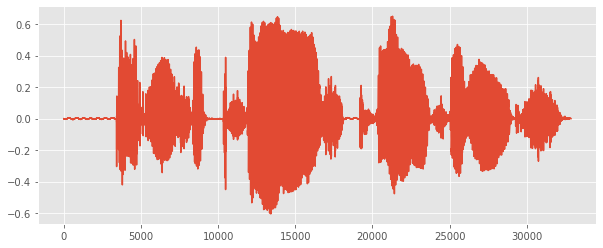

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(10, 4))
plt.plot(audio_input)
plt.show()

Different waveforms are also different lengths. The models we've seen are unable to handle inputs of varying lengths. Logistic regression, for example, expects a fixed set of inputs for each example. A simple technique around this is to extract a fixed number of features from the waveform like the average or max amplitude, etc. However, maybe we can do something more sophisticated using signal processing techniques.

In [ ]:
# listen to the audio file!

import IPython.display as ipd
ipd.Audio(wav_path)

## Spectrograms

The fast [fourier transform](https://en.wikipedia.org/wiki/Fourier_transform?wprov=srpw1_0) (FFT) decomposes a single waveform into a spectrum of frequencies and coefficients (e.g. a set of sine and cosine waves that add up to the original signal through a weighted sum with the coefficients). Applying this to speech, we can treat the coefficients derived from FFT as features. 

A bit of nuance -- FFT works well for a single static waveform but audio signals evolve over time as the speaker says new word. Critically, audio waveforms are non-periodic, so the FFT decomposition *changes over time*. 

To handle this, we chop the waveform signal into windowed segments and compute an FFT per segment. Doing this creates a **spectrogram**. Finally, the **mel scale** is a frequency scale inspired by the fact that humans do not perceive frequencies linearly but rather bias towards lower frequencies. Thus, a **mel spectrogram** is a spectrogram projected onto the mel scale. If we compute the log of the mel spectrogram, we produce the desired **log-mel spectrogram**. For more depth on audio features see:
* [Understanding the Mel Spectrogram](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53). Leland Roberts. 2020.
* Features for audio and speech recognition covered in [Stanford CS224S Slides](http://web.stanford.edu/class/cs224s/syllabus/)
* Speech and language processing. Dan Jurafsky & James Martin. 3rd edition draft. Chp 25: Phonetics. [pdf](https://web.stanford.edu/~jurafsky/slp3/25.pdf) 
* The audio processing library [librosa](https://librosa.org/doc/latest/feature.html) has a range of feature extraction routines beyond just spectrograms
* To try data augmentation training with spectrograms, [SpecAugment](https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html) creates simple masking and time warping transformations of input examples.


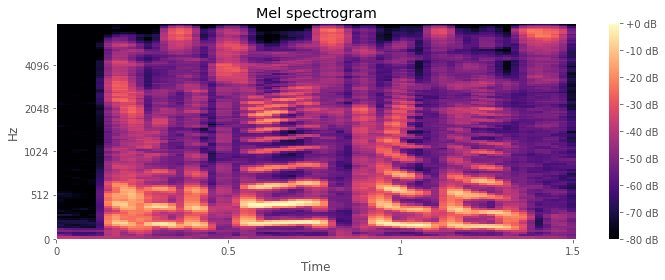

In [ ]:
import librosa     # general speech toolkit 
import librosa.display

wav_mel = librosa.feature.melspectrogram(
    y=audio_input, sr=sample_rate, hop_length=512)

plt.figure(figsize=(10, 4))
librosa.display.specshow(
    librosa.power_to_db(wav_mel, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [ ]:
wav_mel.shape

(128, 65)

We can see the overall shape of this spectrogram roughly  aligns with the waveform above. On the y-axis of the plot, we see different frequences. The lighter the color, the higher the coefficient of that frequency. 

A question remains on how to convert this to a feature. A simple approach is to take the average over time. More sophisticated approaches here can divy the spectrogram temporally into chunks, compute averages per chunk, then concatenate the resulting features together into a single vector.

# Image Data

Images can be different sizes, and take pixel values typically are represented as integers from 0 to 256 (RGB images are represented as multiple copies of an image -- one for each of the threee color channels). A common preprocessing step is to reshape the image to a common size (e.g. 64 pixels width) and take a center crop to produce a 64 x 64 image. Finally, we can divide the input values by 256 to produce a matrix of 3 (channels) x 64 (width) x 64 (height) numbers from 0 to 1.

In [ ]:
!gdown --id 1ARQ0VbB43SYetRNFSgGtfN_b5cp85pgE

Downloading...
From: https://drive.google.com/uc?id=1ARQ0VbB43SYetRNFSgGtfN_b5cp85pgE
To: /content/dog.png
100% 5.03M/5.03M [00:00<00:00, 101MB/s]


Raw image shape: (1840, 2208, 3)
Resized image shape: (64, 76, 3)
Cropped image shape: (64, 64, 3)


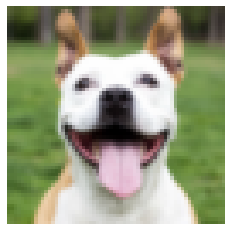

In [ ]:
# scikit-image is a popular library for image preprocessing
from skimage.transform import resize
from skimage.io import imread
from skimage import color

image = imread('./dog.png')
if image.shape[-1] == 4:
  image = image[:, :, :3]
print(f'Raw image shape: {image.shape}')

target_size = 64

def resize_pipeline(image, target_size):
  # find larger and smaller of height vs width
  shape = list(image.shape)
  larger_size = max(shape[:2])
  smaller_size = min(shape[:2])
  ratio = target_size / smaller_size 
  new_larger_size = int(larger_size * ratio)
  new_size = []
  for size in shape[:2]:
    if size == larger_size:
      new_size.append(new_larger_size)
    else:
      new_size.append(target_size)
  new_size.append(shape[2])
  image = resize(image, tuple(new_size), anti_aliasing=True)
  return image

image = resize_pipeline(image, target_size)
print(f'Resized image shape: {image.shape}')

def center_crop(image, target_size):
  shape = list(image.shape)
  y, x = shape[0], shape[1]
  startx = x //2-(target_size//2)
  starty = y //2-(target_size//2)    
  image = image[
    starty: starty + target_size, 
    startx: startx + target_size, 
    :
  ]
  return image

image = center_crop(image, target_size)
print(f'Cropped image shape: {image.shape}')

plt.axis("off")
plt.imshow(image)


## Image descriptor vectors

Typically using the vector of raw pixel values to represent an image for machine learning work does not yield good results. Pixel values are high-dimensional, correlated, and small perturbations can drastically alter pixel values while the image still "looks" the same. Many SOTA systems today for images use deep neural networks which implicitly learn how to featurize pixels for a task. In Week 4, we will experiment with such models.

In many image applications, deep learning approaches are not feasible for computational or other reasons. We can use hand-engineered featurization approaches to create a feature vector from an image. These techniques typically rely on signal processing and perceptual knowledge to extract compact, informative representations from an image. 

The [scikit-image](https://scikit-image.org/docs/stable/auto_examples/index.html#examples-gallery) library provides several classical image featurization transforms. Such hand-engineered transforms can also be helpful for domain-specific image types where specialized filtering/processing might be required.

**Example: Histogram of Oriented Gradients (HOG)**

Let's examine a classical image featurization technique available in scikit.
HOG computes "gradients" of an image by applying an edge-like filter over the pixels. Features are then computed by computing the magnitudes and orientations of the gradient image. We recommend this [blog](https://www.thepythoncode.com/article/hog-feature-extraction-in-python) for more details.

HOG feature shape:
(1764,)
HOG feature:
[0.09231743 0.02726428 0.02174026 ... 0.0405252  0.00777135 0.12949273]
HOG image:


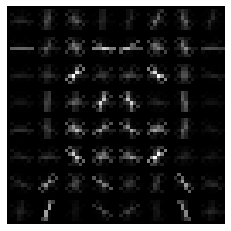

In [ ]:
# use image from above!

from skimage.feature import hog

hog_features, hog_image = hog(
  image, 
  orientations=9,          # number of bins in the histogram we want to create
  pixels_per_cell=(8, 8),  # determines the size of the cell, 
  cells_per_block=(2, 2),  # number of cells per block
  visualize=True, 
  multichannel=True,       # true for rgb
)

print('HOG feature shape:')
print(hog_features.shape)

# these are what we can put into a model
print('HOG feature:')
print(hog_features)

print('HOG image:')
plt.axis("off")
plt.imshow(hog_image, cmap="gray")

When using HOG, we recommend starting the default choices of hyperparameters shown above but you can adjust them to control the level of detail in the HOG features. Non-default values may result in better results! There is a wide range of hand-engineered image descriptors, see the [`skimage.feature`](https://scikit-image.org/docs/stable/api/skimage.feature.html) library for many options. These days the state-of-the-art approach for image features typically uses features obtained from deep learning models, we will cover such features in Week 4. Standard descriptors remain a great place to start when working on a new task, before trying deep learning features. 

# This list is not complete!

It's not possible to enumerate all the various featurization approaches and input modalities you might encounter when building real-world ML systems. Instead, this notebook made an effort to demonstrate a few of the most commonly studied input modalities, and robust, widely-used feature representations for each. As you specialize ML approaches to any domain, it's often highly beneficial to improve your models by researching featurization approaches specific to your input types. 